In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image, display
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from imblearn.combine import SMOTETomek
from sklearn.metrics import roc_auc_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import eli5
from eli5.sklearn import PermutationImportance

# Roadmap

1. Background/Definitions

2. EDA + Preprocessing

3. Model Building

5. Results and Feature Exploration

6. Limitations + Future Works

# Definitions

Biopsy:
A surgical extraction to collect sample cells or tissues for further examination to identify the presence or extent of a disease, digs up a columns of tissue which is invasive.

Hinselmann:
A test method for cervical cancer by examining the cells on an instrument called colposcope. Done by putting some acetic acid on the cervix cells and it’ll highlight areas that might be cancerous.

Schiller:
A test which use applied iodine to the cervix. Does the same thing as Hinselmann except with iodine.

dx: diagnosis

CIN: Cervical intraepithelial neoplasia

HPV: human papillomavirus

In [2]:
# data from https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29
df = pd.read_csv('data/risk_factors_cervical_cancer.csv')
df

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
854,32,2.0,19.0,1.0,0.0,0.0,0.0,1.0,8.0,0.0,...,?,?,0,0,0,0,0,0,0,0
855,25,2.0,17.0,0.0,0.0,0.0,0.0,1.0,0.08,0.0,...,?,?,0,0,0,0,0,0,1,0
856,33,2.0,24.0,2.0,0.0,0.0,0.0,1.0,0.08,0.0,...,?,?,0,0,0,0,0,0,0,0


# EDA + Preprocessing

In [3]:
df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [4]:
# Missing values represented by '?'
# As stated on the UCI documentation, several values were omitted by patients due to privacy concerns. 
df = df.replace('?', np.nan)
df[['STDs: Time since first diagnosis']].head()

,STDs: Time since first diagnosis
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


We can see the data is not missing at random (NMAR) which gives us an idea of what sort of data imputation is appropriate. For example, the "IUD (years)" and "IUD" columns may be missing because the patient has not used an IUD previously which can be inferred by them having the same missing observations. Due to this, the fact that the values are missing may hold a certain meaning so we cannot impute them carelessly.

Text(0.5, 1.0, 'Number of Missing Values Per Column')

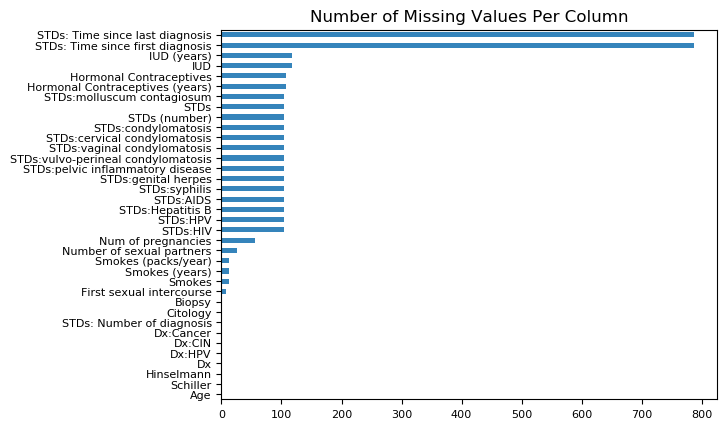

In [5]:
df.isnull().sum().sort_values(ascending=True).plot(kind='barh', fontsize = 8, alpha=0.9).set_title('Number of Missing Values Per Column')

In [6]:
df = df.drop(['STDs: Time since last diagnosis', 'STDs: Time since first diagnosis'], axis=1)

# Impute missing values

For numerical columns (counts) impute using the median. The median is used since outliers will skew the mean. 

For binary columns, missing values will be replace with -1 to represent a "missing" category.

In [7]:
def impute_missing(df):
    for i in df:
        curr_col = df[i]
        
        # binary columns
        if curr_col.value_counts().shape[0] == 2:
            df[i] = curr_col.fillna(-1)
        elif i != 'age_cat':
            df[i] = curr_col.fillna(curr_col.median())
    
    return df

df = impute_missing(df)

print('No nulls in dataframe: ' + str(all([x == 0 for x in df.isna().sum()])))
df.Smokes.value_counts()

No nulls in dataframe: True


0.0    722
1.0    123
-1      13
Name: Smokes, dtype: int64

In [8]:
# based on documentation, all columns should either be an integer or float
df.dtypes

Age                                    int64
Number of sexual partners             object
First sexual intercourse              object
Num of pregnancies                    object
Smokes                                object
Smokes (years)                        object
Smokes (packs/year)                   object
Hormonal Contraceptives               object
Hormonal Contraceptives (years)       object
IUD                                   object
IUD (years)                           object
STDs                                  object
STDs (number)                         object
STDs:condylomatosis                   object
STDs:cervical condylomatosis          object
STDs:vaginal condylomatosis           object
STDs:vulvo-perineal condylomatosis    object
STDs:syphilis                         object
STDs:pelvic inflammatory disease      object
STDs:genital herpes                   object
STDs:molluscum contagiosum            object
STDs:AIDS                             object
STDs:HIV  

In [9]:
# convert all non-integer columns to float type
# NaN values are floats
for i in df:
    curr_col = df[i]
    if curr_col.dtype != 'int64':
        df[i] = df[i].apply(float)

In [10]:
df.dtypes

Age                                     int64
Number of sexual partners             float64
First sexual intercourse              float64
Num of pregnancies                    float64
Smokes                                float64
Smokes (years)                        float64
Smokes (packs/year)                   float64
Hormonal Contraceptives               float64
Hormonal Contraceptives (years)       float64
IUD                                   float64
IUD (years)                           float64
STDs                                  float64
STDs (number)                         float64
STDs:condylomatosis                   float64
STDs:cervical condylomatosis          float64
STDs:vaginal condylomatosis           float64
STDs:vulvo-perineal condylomatosis    float64
STDs:syphilis                         float64
STDs:pelvic inflammatory disease      float64
STDs:genital herpes                   float64
STDs:molluscum contagiosum            float64
STDs:AIDS                         

In [11]:
# create categorical column out of age for cleaner visualizations
df['age_cat'] = pd.cut(df.Age, bins=[0,18,30, 40, 50, 60, 90], labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-90'])
df[['Age', 'age_cat']].head()

,Age,age_cat
0,18,0-18
1,15,0-18
2,34,31-40
3,52,51-60
4,46,41-50


Text(0, 0.5, 'count')

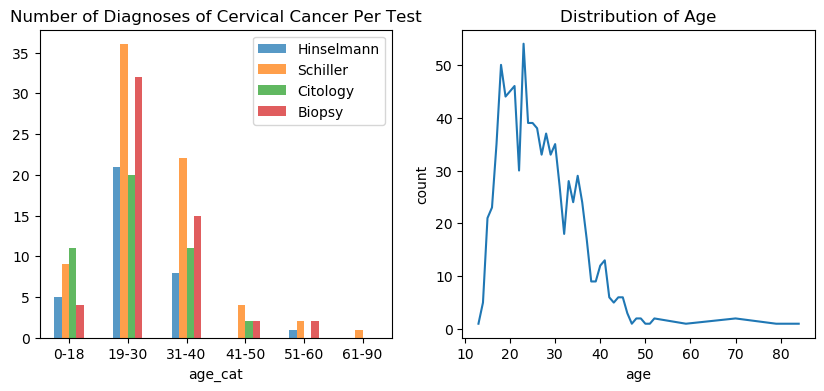

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
df.groupby('age_cat')[['Hinselmann', 'Schiller', 'Citology', 'Biopsy']].sum().plot(kind='bar', alpha=0.75, rot=0, title='Number of Diagnoses of Cervical Cancer Per Test', ax=ax1)
ax = df['Age'].value_counts().sort_index().plot(title='Distribution of Age', ax=ax2)
ax.set_xlabel("age")
ax.set_ylabel("count")

Biopsy is invasive so that could explain why it's not used as often for younger people. Overall it seems like the Schiller and Biopsy tests are the most popular. For older people, only the Schiller test was used. Hinselmann is the least common. Citology most common for younger children and sees less use as one ages. 

Too many columns and no idea which ones are important, so the plan is to shove it all in a model and have it tell us which ones have the most predictive power for cervical cancer. After we have this information, we can then examine those specific columns in closer detail.

# Model Building

In [13]:
# randomly split the data into a 70:30 train test split
X = df.drop(['Schiller', 'Hinselmann', 'Citology', 'Biopsy', 'age_cat'], axis=1)
y = df['Biopsy'] # the 'Biopsy' column will be the target outcome due to the test's reliability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
X_test_copy = X_test.copy(deep=True)
X_train_copy = X_train.copy(deep=True)

Baseline Model w/ no hyperparameter tuning

In [14]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print("Accuracy score: ", sklearn.metrics.accuracy_score(y_test, preds))

Accuracy score:  0.8682170542635659


In [15]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns,  
                                class_names=[str(item) for item in y.unique()],
                                filled=True)

# Draw graph
def view_pydot(pdot):
    """display pydot graph inline without having to save the image"""
    plt = Image(pdot.create_png())
    display(plt)

graph = pydotplus.graph_from_dot_data(dot_data)

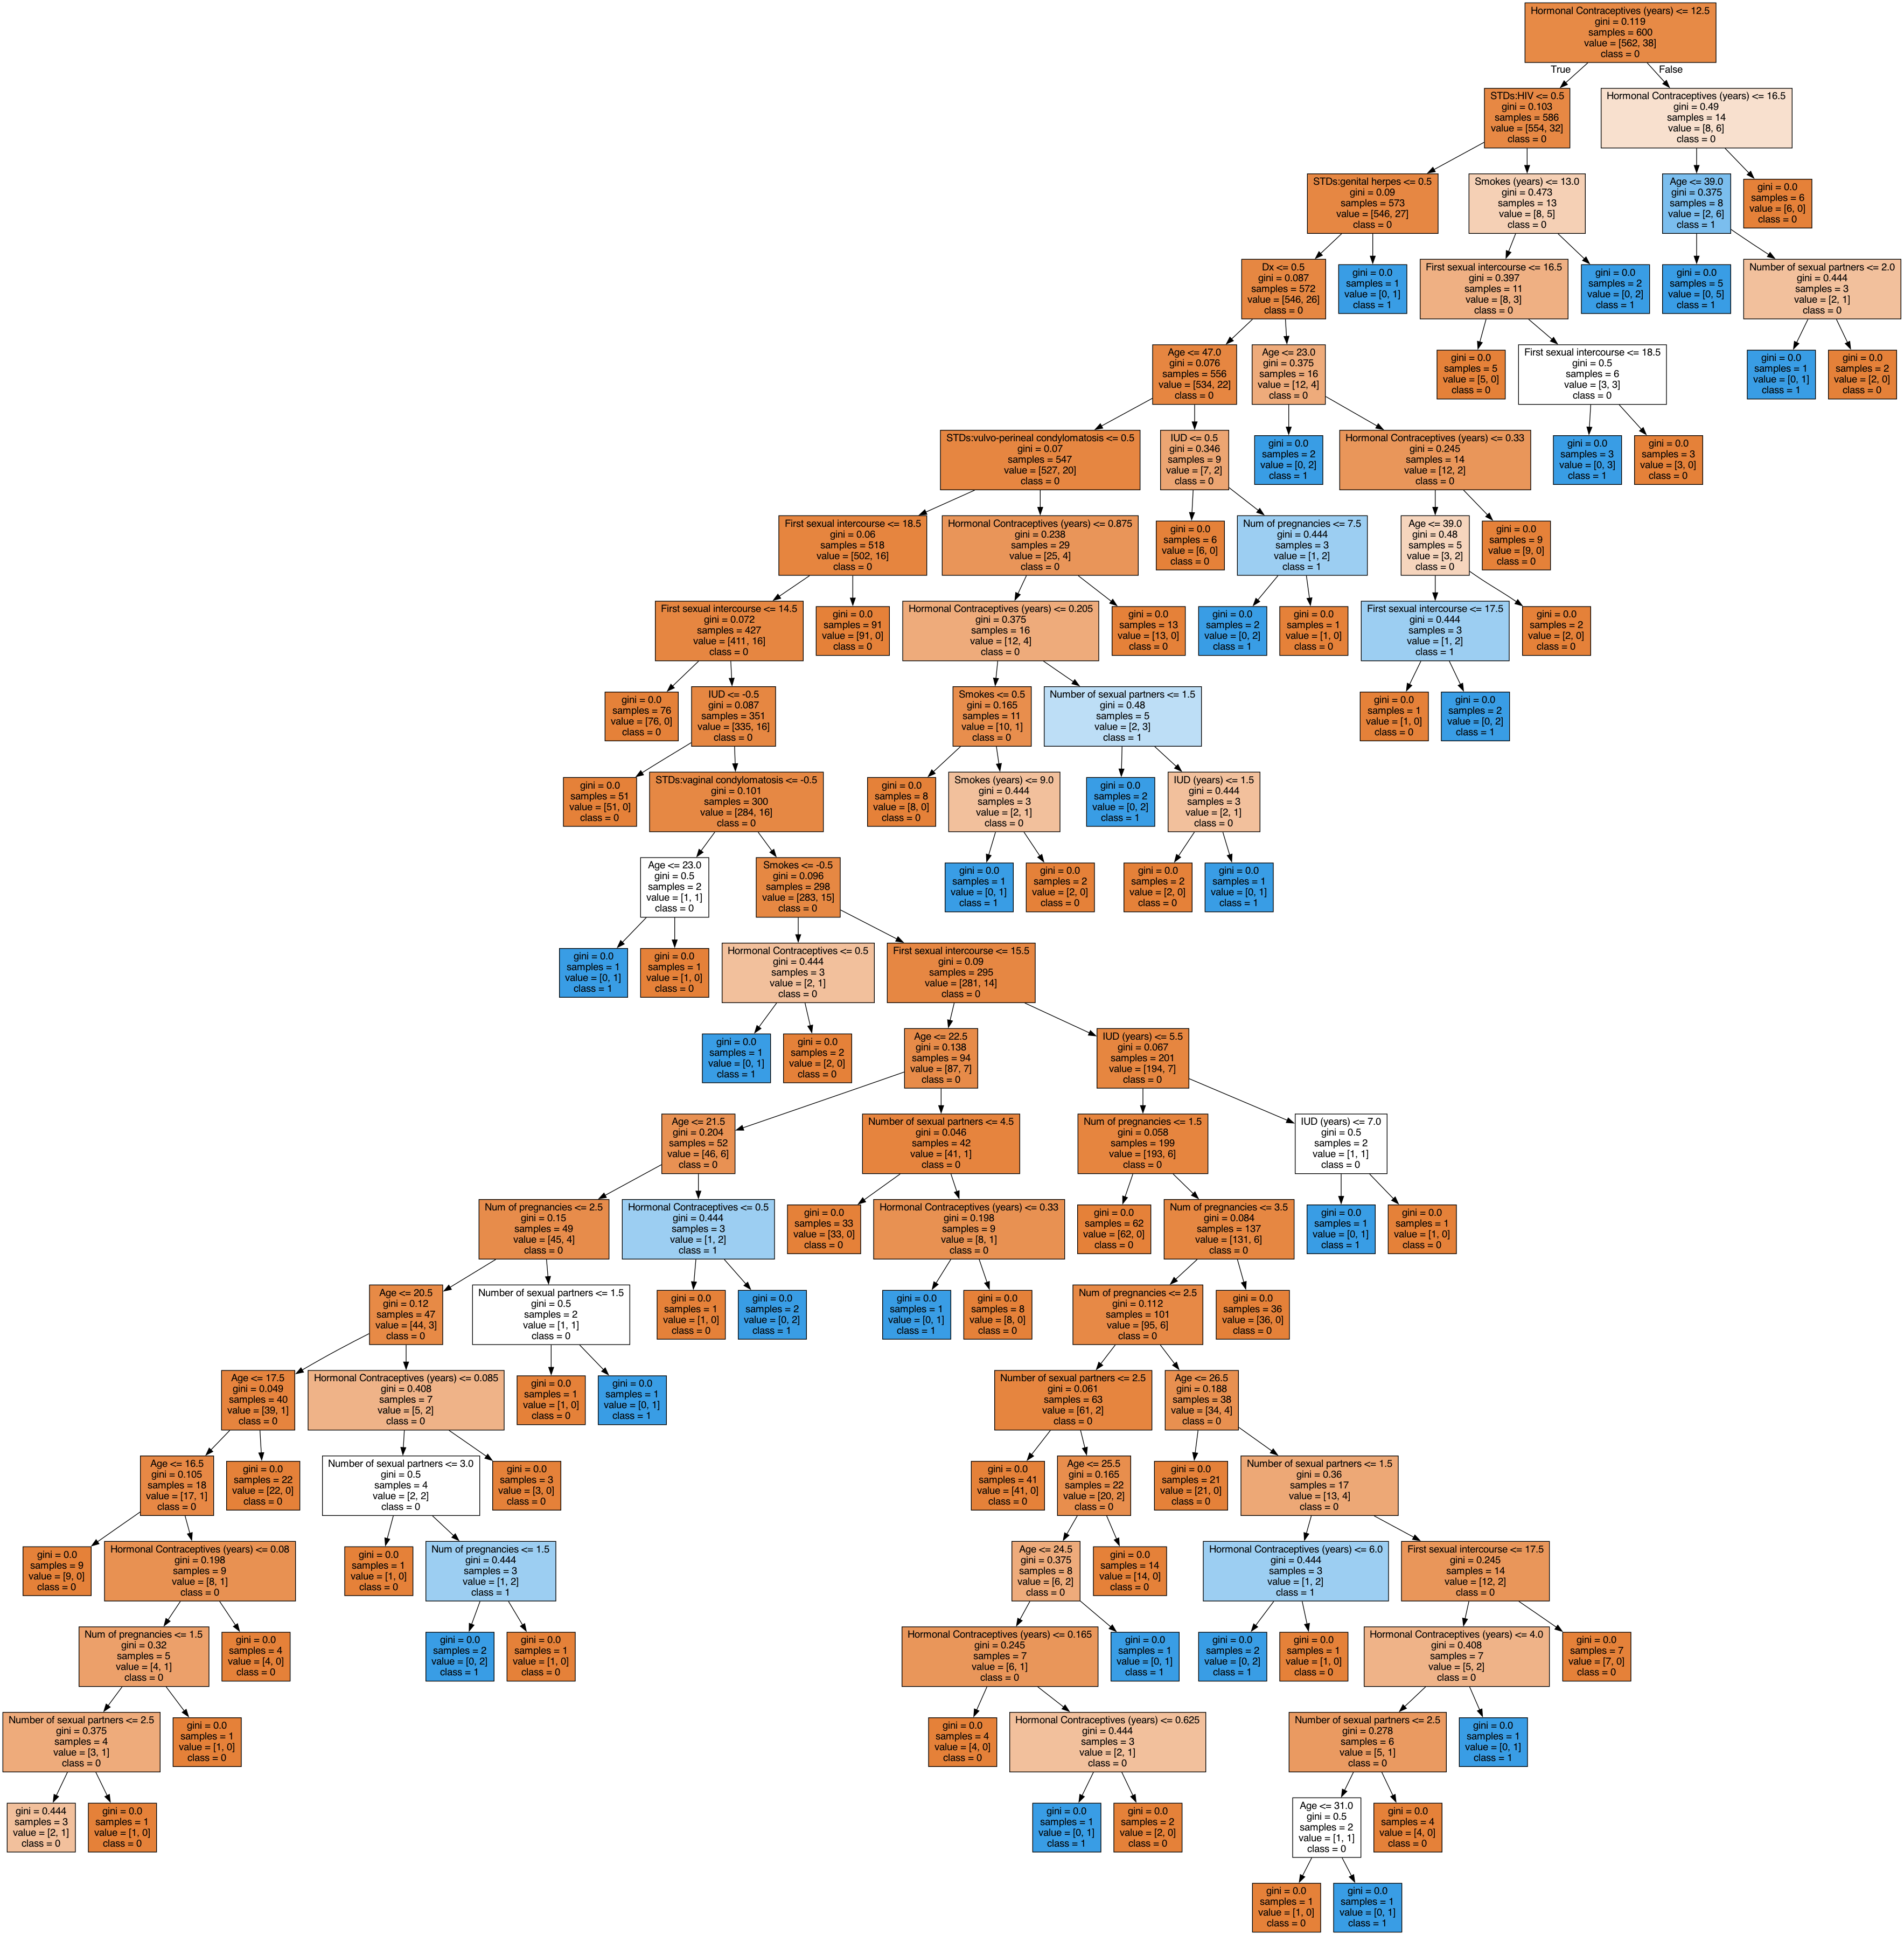

In [16]:
view_pydot(graph)

### Model Tuning

In [17]:
# outcomes are unbalanced with many more negative results
y.value_counts()

0    803
1     55
Name: Biopsy, dtype: int64

In [18]:
# technique that uses SMOTE oversampling and Tomek links undersampling to create synthetic data
# https://www.justintodata.com/imbalanced-data-machine-learning-classification/

cc = SMOTETomek(random_state=3)
X_train, y_train = cc.fit_resample(X_train, y_train)

# now there's an equal amount of positive and negative diagnoses
y_train.value_counts()

0    556
1    556
Name: Biopsy, dtype: int64

In [19]:
# hyperparameter tuning w/ randomized grid search
param_grid={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }
# random forest classifier is a "forest" of decision trees
rf = RandomForestClassifier(random_state=546)
rf_random = RandomizedSearchCV(rf, param_grid, n_iter=500, scoring='accuracy', n_jobs=-1, cv=3)
model_random = rf_random.fit(X_train,y_train)
print('Best hyperparameters are: '+ str(model_random.best_params_))

Best hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 260}


In [20]:
rf_clf = RandomForestClassifier(criterion='gini', max_depth=50, max_features=6, min_samples_leaf=1, 
                                    min_samples_split=4, n_estimators=410, random_state=34)
rf_clf.fit(X_train, y_train)
preds = rf_clf.predict(X_test)

print("Accuracy score: ", sklearn.metrics.accuracy_score(y_test, preds))

Accuracy score:  0.9341085271317829


# Results

In [21]:
permutations = PermutationImportance(rf_clf, random_state=34).fit(X_test, y_test)
eli5.show_weights(permutations, feature_names = X_test.columns.tolist(), top=16)

Weight,Feature
0.0140 ± 0.0144,First sexual intercourse
0.0132 ± 0.0116,Number of sexual partners
0.0101 ± 0.0093,Age
0.0093 ± 0.0167,Hormonal Contraceptives (years)
0.0078 ± 0.0000,STDs: Number of diagnosis
0.0054 ± 0.0062,Num of pregnancies
0.0054 ± 0.0038,STDs
0.0054 ± 0.0038,STDs (number)
0.0047 ± 0.0031,Smokes (packs/year)
0.0039 ± 0.0000,IUD (years)


In [22]:
def pdp_plotter(lst):
    PartialDependenceDisplay.from_estimator(rf_clf, X_train, lst)

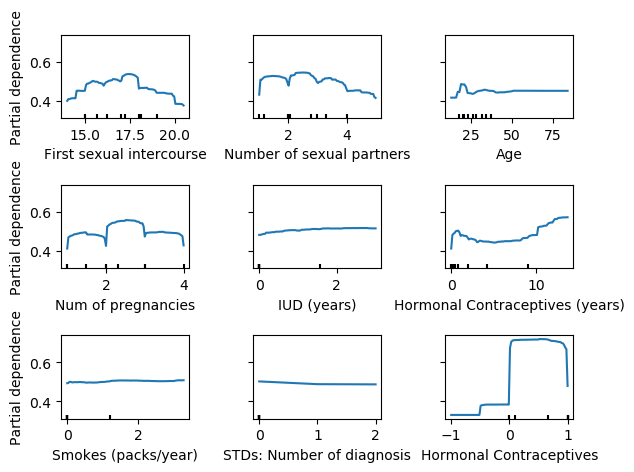

In [23]:
pdp_plotter(['First sexual intercourse', 'Number of sexual partners', 'Age', 'Num of pregnancies', 
             'IUD (years)', 'Hormonal Contraceptives (years)', 'Smokes (packs/year)', 'STDs: Number of diagnosis', 
             'Hormonal Contraceptives'])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.8)

# Limitations + Future Work

limitations: data is a small population from Venezuela so may not be representative of other regions

Unbalanced data between age distribution.

This same work can be adapted to examine the partial dependencies for the other tests, like Citology, Hinselmann, and Schiller (replace what the y variable is assigned to then rerun everything)

TODO